In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVCal
from pyuvdata import UVData
import glob
import aipy
from hera_qm import ant_metrics
from hera_cal import omni, utils, firstcal
from matplotlib.colors import LogNorm
import sys
from copy import deepcopy
import omnical
%matplotlib notebook 

# Data location

In [2]:
pols = ['xx','xy','yx','yy']
antpols = ['x','y']
#origin = '/lustre/aoc/projects/hera/zali/HERA2015/'
origin = './'
time = '2457555.42443'
#time = '2457555.50099'
day = time.split('.')[0]
dataFileList = [origin + day + '/zen.' + time + '.' + pol + '.HH.uvc' for pol in pols]
ant_metrics_json = origin + day + '/zen.' + time + '.HH.uvc.ant_metrics.json'
fcFileList = [origin + day + '/zen.' + time + '.' + pol + '.HH.uvc.first.calfits' for pol in [pols[0],pols[3]]]
omnicalFile = origin + day + '/zen.' + time + '.HH.uvc.omni.calfits'
omniVisFile = origin + day + '/zen.' + time + '.HH.uvc.vis.uvfits'

In [3]:
CAL_PATH = '/users/jsdillon/hera_sandbox/jsd/calfiles'
calfile = 'hsa7458_v001'
if CAL_PATH not in sys.path:
    sys.path.append(CAL_PATH)

# Load data

In [4]:
data = UVData()
data.read_miriad(dataFileList)
am = ant_metrics.load_antenna_metrics(ant_metrics_json)

Altitude is not present in Miriad file, using known location values for HERA.
antenna number 112 has visibilities associated with it, but it has a position of (0,0,0)
antenna_diameters is not set. Using known values for HERA.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


# Perform Omnical Interactively

In [5]:
freqs = data.freq_array[0,:] / 1e9
aa = utils.get_aa_from_calfile(freqs[0], calfile)
ex_ants = list(set([ant[0] for ant in am['xants']]))

ex_ants.append(43)
print 'Manually removing antenna 43'

info = omni.aa_to_info(aa, pols=['x','y'], crosspols=['xx','yy'], ex_ants=ex_ants)
#info = omni.aa_to_info(aa, pols=['x'], ex_ants=ex_ants) # this is for only running 1pol omnical
#info = omni.aa_to_info(aa, pols=['y'], ex_ants=ex_ants) # this is for only running 1pol omnical

_, g0, _, _ = omni.from_fits(fcFileList) #check and see if this is the same as aaron

Manually removing antenna 43
./2457555/zen.2457555.42443.xx.HH.uvc.first.calfits
./2457555/zen.2457555.42443.yy.HH.uvc.first.calfits


## Extract a single integration

In [6]:
datapack, wgtpack = firstcal.UVData_to_dict([data])
for bl in datapack.keys():
    for pol in datapack[bl].keys():
        datapack[bl][pol] = np.array(datapack[bl][pol][0:1,:], dtype=np.complex64)
for antpol in g0.keys():
    for ant in g0[antpol].keys():
        g0[antpol][ant] = np.array(g0[antpol][ant][0:1,:], dtype=np.complex64)        

## Optionally, reverse x and y

In [7]:
if False:
    rev_data = deepcopy(datapack)
    for bl in datapack.keys():
        rev_data[bl]['xx'] = datapack[bl]['yy']
        rev_data[bl]['xy'] = datapack[bl]['yx']
        rev_data[bl]['yx'] = datapack[bl]['xy'] 
        rev_data[bl]['yy'] = datapack[bl]['xx']

    rev_g0 = deepcopy(g0)
    for ant in g0['x'].keys():
        rev_g0['x'][ant] = g0['y'][ant]
        rev_g0['y'][ant] = g0['x'][ant]    

    datapack, g0 = rev_data, rev_g0

## Run Omnical Regularly

In [8]:
m1, g1, v1 = omnical.calib.logcal(datapack, info, gains=g0)
m2, g2, v2 = omnical.calib.lincal(datapack, info, gains=g1, vis=v1)
# del v2['xy']
# del v2['yx']
g3, v3 = omni.remove_degen(info, g2, v2, g0, minV=False)

In [12]:
# np.linalg.norm(v3['xx'][9,20][0,:] - vis.get_data(9,20,'xx')[0,:]) / np.linalg.norm(v3['xx'][9,20][0,:])

<IPython.core.display.Javascript object>


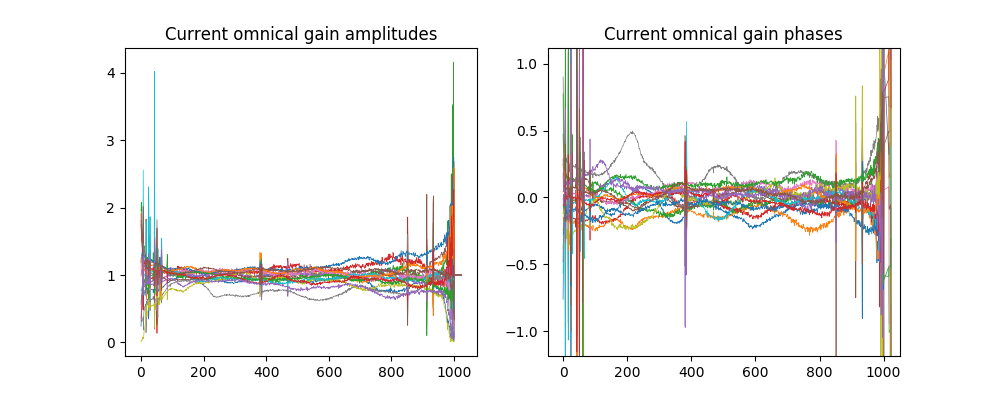

In [9]:
plt.figure(figsize=(10,4))
for ant in g3['x'].keys():
    plt.subplot(121)
    plt.plot(np.abs(g3['x'][ant][0,:] / g0['x'][ant][0,:]), '-', lw=.5)
    plt.title('Current omnical gain amplitudes')
    plt.subplot(122)
    plt.title('Current omnical gain phases')
    plt.plot(np.angle(g3['x'][ant][0,:] / g0['x'][ant][0,:]), '-', lw=.5)

In [11]:
# plt.figure();
# plt.semilogy(np.abs(g3_fc_2pol['x'][9][0,:] - g3['x'][9][0,:] / g0['x'][9][0,:]))
# plt.title('Abs(New hera_cal.omni gain solution - manually divided out firstcal)')

# Apply firstcal gains ahead of time and Compare 4pol and 2pol remove degen

In [12]:
freqs = data.freq_array[0,:] / 1e9
aa = utils.get_aa_from_calfile(freqs[0], calfile)
ex_ants = list(set([ant[0] for ant in am['xants']]))
ex_ants.append(43)
print 'Manually removing antenna 43'

_, g0, _, _ = omni.from_fits(fcFileList) #check and see if this is the same as aaron
for antpol in g0.keys():
    for ant in g0[antpol].keys():
        g0[antpol][ant] = np.array(g0[antpol][ant][0:1,:], dtype=np.complex64)        
unit_gains = deepcopy(g0)
for antpol in unit_gains.keys():
    for ant in unit_gains[antpol].keys():
        unit_gains[antpol][ant] = np.ones_like(unit_gains[antpol][ant])
        unit_gains[antpol][ant] = np.array(unit_gains[antpol][ant], dtype=np.complex64)

Manually removing antenna 43
/lustre/aoc/projects/hera/zali/HERA2015/2457555/IDR3/zen.2457555.42443.xx.HH.uvc.first.calfits
/lustre/aoc/projects/hera/zali/HERA2015/2457555/IDR3/zen.2457555.42443.yy.HH.uvc.first.calfits


In [13]:
info = omni.aa_to_info(aa, pols=['x','y'], ex_ants=ex_ants)
#info = omni.aa_to_info(aa, pols=['x'], ex_ants=ex_ants) # this is for only running 1pol omnical


In [14]:
datapack_fc, wgtpack_fc = deepcopy(datapack), deepcopy(wgtpack)
for bl in datapack_fc.keys():
    if bl[0] not in ex_ants and bl[1] not in ex_ants:
        for pol in datapack_fc[bl].keys():
            datapack_fc[bl][pol] = datapack_fc[bl][pol][0:1,:] / (g0[pol[0]][bl[0]] * np.conj(g0[pol[1]][bl[1]]))
            datapack_fc[bl][pol] = np.array(datapack_fc[bl][pol], dtype=np.complex64)

In [15]:
m1_fc, g1_fc, v1_fc = omnical.calib.logcal(datapack_fc, info, gains=unit_gains)
m2_fc, g2_fc, v2_fc = omnical.calib.lincal(datapack_fc, info, gains=g1_fc, vis=v1_fc)
g3_fc_4pol, v3_fc_4pol = omni.remove_degen(info, g2_fc, v2_fc, unit_gains, minV=False)


v2_copy = deepcopy(v2_fc)
del v2_copy['xy']
del v2_copy['yx']
g3_fc_2pol, v3_fc_2pol = omni.remove_degen(info, g2_fc, v2_copy, unit_gains, minV=False)    


In [16]:
def calibrate_datapack(datapack, g):
    calibrated = deepcopy(datapack)
    ants = g.values()[0].keys()    
    for (ant1, ant2) in calibrated.keys():
        if ant1 in ants and ant2 in ants:
            for pol in calibrated[(ant1, ant2)].keys():
                if pol[0] in g.keys() and pol[1] in g.keys():
                    calibrated[(ant1, ant2)][pol] /= (g[pol[0]][ant1] * np.conj(g[pol[1]][ant2]))
                else:
                    del calibrated[(ant1, ant2)][pol]
        else:
            del calibrated[(ant1, ant2)]
    return calibrated

In [17]:
fc_vis_ant9xx = {(ant1,ant2): vis['xx'] for (ant1,ant2),vis in 
                 datapack_fc.items() if ant1 == 9 and ant2 != 9}
calibrated_4pol = calibrate_datapack(datapack_fc, g3_fc_4pol)
calibrated_2pol = calibrate_datapack(datapack_fc, g3_fc_2pol)
calibrated_4pol_ant9xx = {(ant1,ant2): vis['xx'] for (ant1,ant2),vis in 
                          calibrated_4pol.items() if ant1 == 9 and ant2 != 9}
calibrated_2pol_ant9xx = {(ant1,ant2): vis['xx'] for (ant1,ant2),vis in 
                          calibrated_2pol.items() if ant1 == 9 and ant2 != 9}

* ~~TODO: look into calibrated visibilities and see if they are as noisy~~ They are.
* TODO: try adding large artificial noise to xy-visibilities

In [18]:
def plot_amp_and_phase(pltdata, title, pltfcn1):
    plt.figure(figsize=(10,4))
    for index in pltdata.keys():
        plt.subplot(121)
        pltfcn1(np.abs(pltdata[index][0,:]), '-', lw=.5)
        plt.title(title + ' amplitudes')
        plt.subplot(122)
        plt.plot(np.angle(pltdata[index][0,:]), '-', lw=.5)
        plt.title(title + ' phases')        

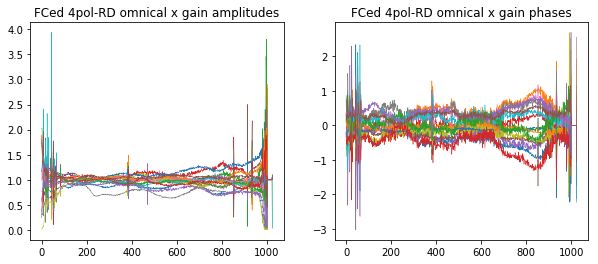

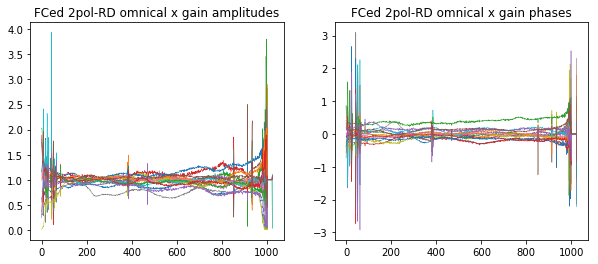

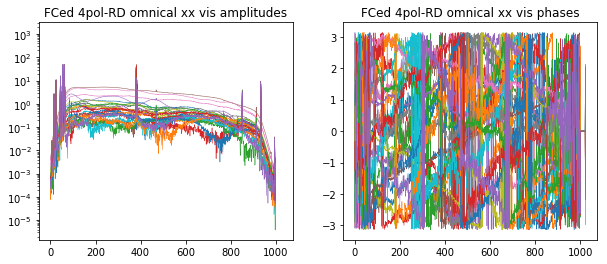

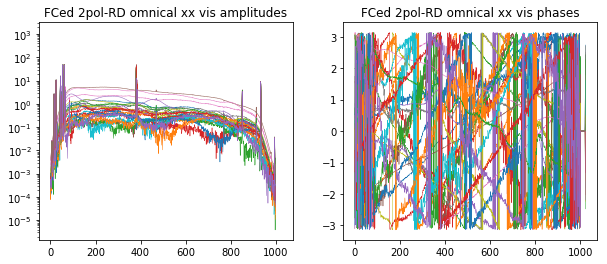

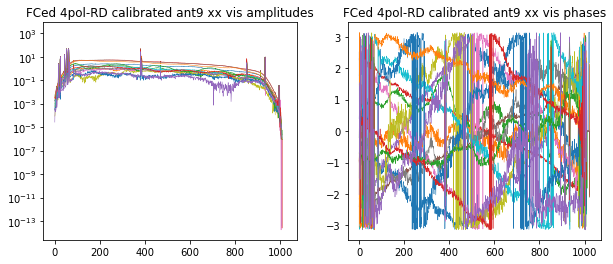

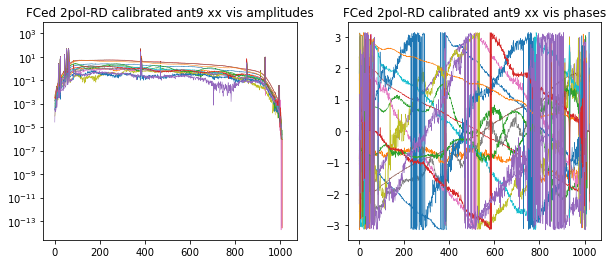

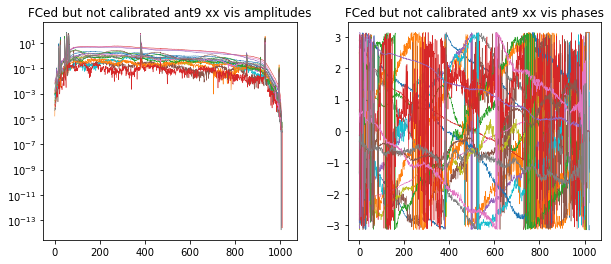

In [19]:


toPlot = [g3_fc_4pol['x'], g3_fc_2pol['x'], 
          v3_fc_4pol['xx'], v3_fc_2pol['xx'],
          calibrated_4pol_ant9xx, calibrated_2pol_ant9xx, 
          fc_vis_ant9xx]
titles = ['FCed 4pol-RD omnical x gain', 'FCed 2pol-RD omnical x gain',
          'FCed 4pol-RD omnical xx vis', 'FCed 2pol-RD omnical xx vis',
          'FCed 4pol-RD calibrated ant9 xx vis', 'FCed 2pol-RD calibrated ant9 xx vis',
          'FCed but not calibrated ant9 xx vis']
pltfcns = [plt.plot, plt.plot,
           plt.semilogy, plt.semilogy,
           plt.semilogy, plt.semilogy, 
           plt.semilogy]

for plot,title,pltfcn in zip(toPlot, titles, pltfcns):
    plot_amp_and_phase(plot, title, pltfcn)

# How does 4-pol and 2-pol omnical compare to one another?

In [20]:
freqs = data.freq_array[0,:] / 1e9
aa = utils.get_aa_from_calfile(freqs[0], calfile)
ex_ants = list(set([ant[0] for ant in am['xants']]))
ex_ants.append(43)
print 'Manually removing antenna 43'

_, g0, _, _ = omni.from_fits(fcFileList) #check and see if this is the same as aaron
for antpol in g0.keys():
    for ant in g0[antpol].keys():
        g0[antpol][ant] = np.array(g0[antpol][ant][0:1,:], dtype=np.complex64)        
unit_gains = deepcopy(g0)
for antpol in unit_gains.keys():
    for ant in unit_gains[antpol].keys():
        unit_gains[antpol][ant] = np.ones_like(unit_gains[antpol][ant])
        unit_gains[antpol][ant] = np.array(unit_gains[antpol][ant], dtype=np.complex64)

Manually removing antenna 43
/lustre/aoc/projects/hera/zali/HERA2015/2457555/IDR3/zen.2457555.42443.xx.HH.uvc.first.calfits
/lustre/aoc/projects/hera/zali/HERA2015/2457555/IDR3/zen.2457555.42443.yy.HH.uvc.first.calfits


In [21]:
datapack_fc, wgtpack_fc = deepcopy(datapack), deepcopy(wgtpack)
for bl in datapack_fc.keys():
    if bl[0] not in ex_ants and bl[1] not in ex_ants:
        for pol in datapack_fc[bl].keys():
            datapack_fc[bl][pol] = datapack_fc[bl][pol][0:1,:] / (g0[pol[0]][bl[0]] * np.conj(g0[pol[1]][bl[1]]))
            datapack_fc[bl][pol] = np.array(datapack_fc[bl][pol], dtype=np.complex64)

In [22]:
info = omni.aa_to_info(aa, pols=['x'], ex_ants=ex_ants) # this is for only running 1pol omnical
m1_fc, g1_fc, v1_fc = omnical.calib.logcal(datapack_fc, info, gains=unit_gains)
m2_fc, g2_fc, v2_fc = omnical.calib.lincal(datapack_fc, info, gains=g1_fc, vis=v1_fc)
g3_fc_1pol, v3_fc_1pol = omni.remove_degen(info, g2_fc, v2_fc, unit_gains, minV=False)

In [23]:
rev_data_fc = deepcopy(datapack_fc)
for bl in datapack_fc.keys():
    rev_data_fc[bl]['xx'] = datapack_fc[bl]['yy']
    rev_data_fc[bl]['xy'] = datapack_fc[bl]['yx']
    rev_data_fc[bl]['yx'] = datapack_fc[bl]['xy'] 
    rev_data_fc[bl]['yy'] = datapack_fc[bl]['xx']
m1_fc_rev, g1_fc_rev, v1_fc_rev = omnical.calib.logcal(rev_data_fc, info, gains=unit_gains)
m2_fc_rev, g2_fc_rev, v2_fc_rev = omnical.calib.lincal(rev_data_fc, info, gains=g1_fc_rev, vis=v1_fc_rev)
g3_fc_1pol_rev, v3_fc_1pol_rev = omni.remove_degen(info, g2_fc_rev, v2_fc_rev, unit_gains, minV=False)
g3_fc_1pol['y'] = g3_fc_1pol_rev['x']
v3_fc_1pol['yy'] = v3_fc_1pol_rev['xx']


In [24]:
info = omni.aa_to_info(aa, pols=['x','y'], ex_ants=ex_ants)
m1_fc, g1_fc, v1_fc = omnical.calib.logcal(datapack_fc, info, gains=unit_gains)
m2_fc, g2_fc, v2_fc = omnical.calib.lincal(datapack_fc, info, gains=g1_fc, vis=v1_fc)
v2_fc_copy = deepcopy(v2_fc)
del v2_fc['xy']
del v2_fc['yx']
g3_fc_2pol, v3_fc_2pol = omni.remove_degen(info, g2_fc, v2_fc, unit_gains, minV=False)

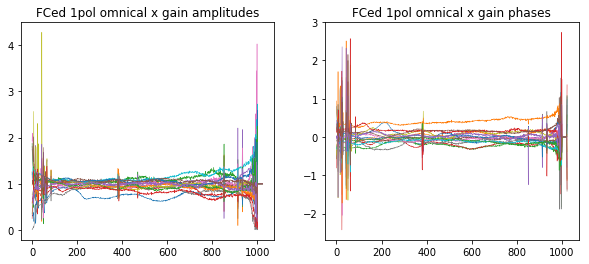

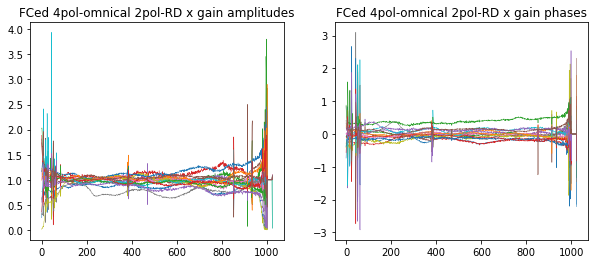

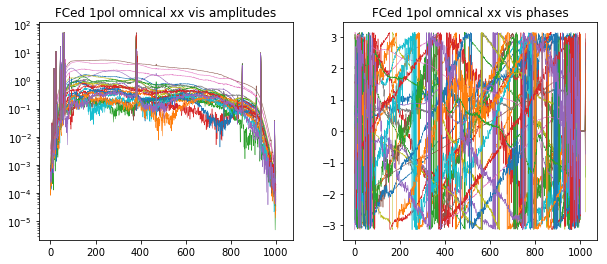

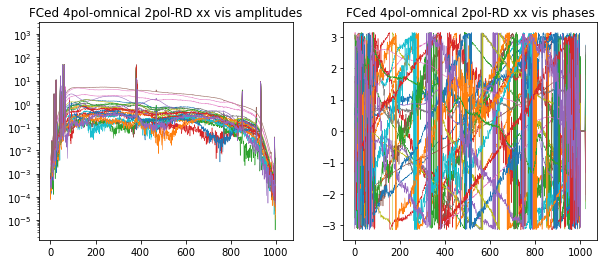

In [25]:
toPlot = [g3_fc_1pol['x'], g3_fc_2pol['x'], 
          v3_fc_1pol['xx'], v3_fc_2pol['xx']]
titles = ['FCed 1pol omnical x gain', 'FCed 4pol-omnical 2pol-RD x gain',
          'FCed 1pol omnical xx vis', 'FCed 4pol-omnical 2pol-RD xx vis']
pltfcns = [plt.plot, plt.plot,
           plt.semilogy, plt.semilogy]

for plot,title,pltfcn in zip(toPlot, titles, pltfcns):
    plot_amp_and_phase(plot, title, pltfcn)

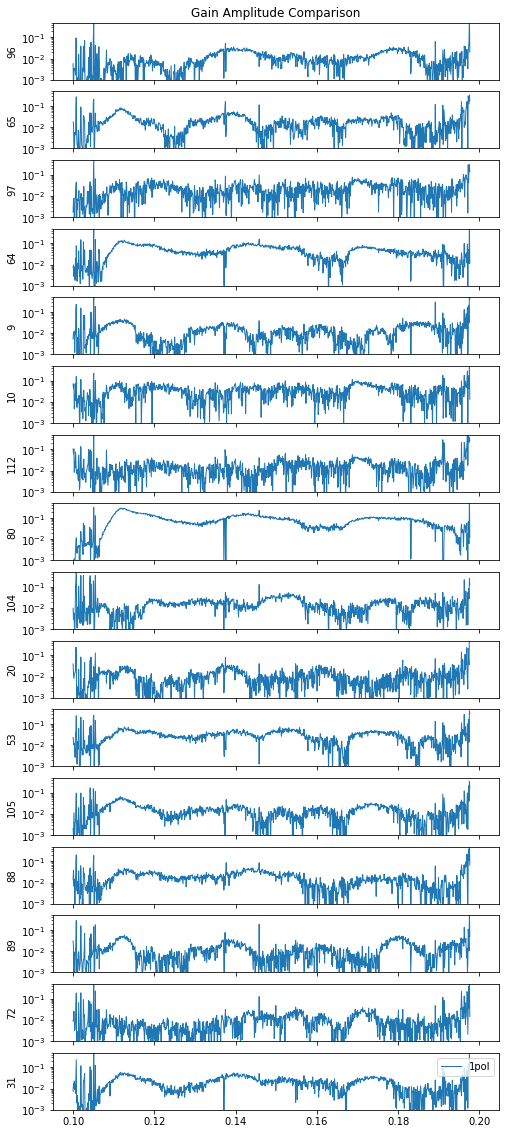

In [26]:
fig, axes = plt.subplots(len(g3_fc_1pol['x']), sharex='col', figsize = (8,20))

for ant, ax in zip(g3_fc_1pol['x'].keys(), axes):
    ax.semilogy(freqs,np.abs(np.abs(g3_fc_1pol['x'][ant][0,:])-np.abs(g3_fc_2pol['x'][ant][0,:])), lw=1, label='1pol')
#    ax.plot(freqs,np.abs(g3_fc_2pol['x'][ant][0,:]), lw=1, label='2pol')
    ax.set_ylabel(str(ant))
    ax.set_ylim([.001,.5])
axes[-1].legend(loc='upper right')
axes[0].set_title('Gain Amplitude Comparison')

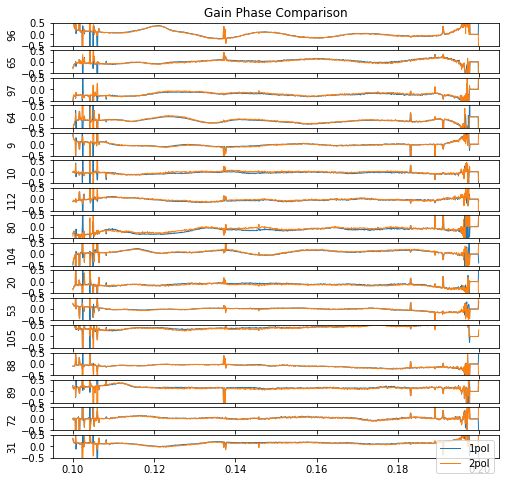

In [27]:
fig, axes = plt.subplots(len(g3_fc_1pol['x']), sharex='col', figsize = (8,8))

for ant, ax in zip(g3_fc_1pol['x'].keys(), axes):
    ax.plot(freqs,np.angle(g3_fc_1pol['x'][ant][0,:]), lw=1, label='1pol')
    ax.plot(freqs,np.angle(g3_fc_2pol['x'][ant][0,:]), lw=1, label='2pol')
    ax.set_ylabel(str(ant))
    ax.set_ylim([-.5,.5])
axes[-1].legend(loc='upper right')
axes[0].set_title('Gain Phase Comparison')

# Compare noise on gains

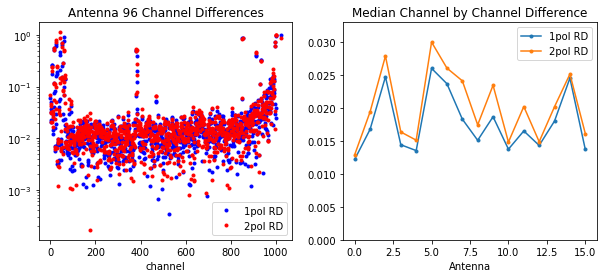

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(121)
ants = g3_fc_1pol['x'].keys()
ant = ants[0]
plt.semilogy(np.abs(np.diff(g3_fc_1pol['x'][ant][0,:])),'b.', label='1pol RD')
plt.plot(np.abs(np.diff(g3_fc_2pol['x'][ant][0,:])),'r.', label='2pol RD')
plt.title('Antenna ' + str(ant) + ' Channel Differences')
plt.xlabel('channel')
plt.legend()

plt.subplot(122)
meds_1pol, meds_2pol = [], []
for ant in ants:
    meds_1pol.append(np.median(np.abs(np.diff(g3_fc_1pol['x'][ant][0,:]))))
    meds_2pol.append(np.median(np.abs(np.diff(g3_fc_2pol['x'][ant][0,:]))))

meds_1pol = np.array(meds_1pol)
meds_2pol = np.array(meds_2pol)
    
plt.plot(np.abs(meds_1pol), '.-', label='1pol RD')
plt.plot(np.abs(meds_2pol), '.-', label='2pol RD')
plt.xlabel('Antenna')
plt.ylim([0,1.1*np.max(np.append(meds_1pol,meds_2pol))])
plt.title('Median Channel by Channel Difference')
plt.legend()

# Compare noise on model visibilities

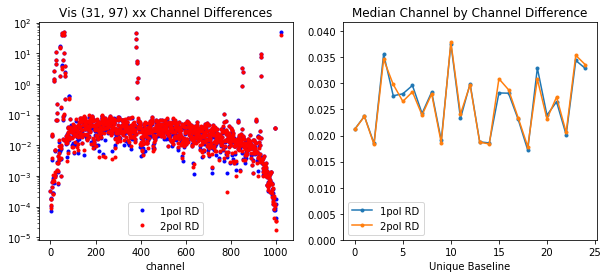

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(121)
bls = v3_fc_1pol['xx'].keys()
bl = bls[11]
plt.semilogy(np.abs(np.diff(v3_fc_1pol['xx'][bl][0,:])),'b.', label='1pol RD')
plt.plot(np.abs(np.diff(v3_fc_2pol['xx'][bl][0,:])),'r.', label='2pol RD')
plt.title('Vis ' + str(bl) + ' xx Channel Differences')
plt.xlabel('channel')
plt.legend()

plt.subplot(122)
meds_1pol, meds_2pol = [], []
for bl in bls:
    meds_1pol.append(np.median(np.abs(np.diff(v3_fc_1pol['xx'][bl][0,:]))))
    meds_2pol.append(np.median(np.abs(np.diff(v3_fc_2pol['xx'][bl][0,:]))))

meds_1pol = np.array(meds_1pol)
meds_2pol = np.array(meds_2pol)
    
plt.plot(np.abs(meds_1pol), '.-', label='1pol RD')
plt.plot(np.abs(meds_2pol), '.-', label='2pol RD')
plt.xlabel('Unique Baseline')
plt.ylim([0,1.1*np.max(np.append(meds_1pol,meds_2pol))])
plt.title('Median Channel by Channel Difference')
plt.legend()

# Compare noise on calibrated visibilities

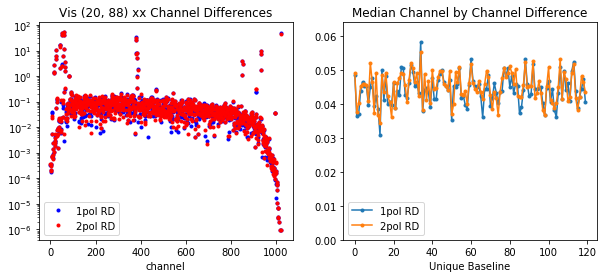

In [30]:
calibrated_1pol = calibrate_datapack(datapack_fc, g3_fc_1pol)
calibrated_2pol = calibrate_datapack(datapack_fc, g3_fc_2pol)


plt.figure(figsize=(10,4))
plt.subplot(121)
bls = [(ant1,ant2) for (ant1,ant2) in calibrated_1pol.keys() if ant1 != ant2]
bl = bls[9]
plt.semilogy(np.abs(np.diff(calibrated_1pol[bl]['xx'][0,:])),'b.', label='1pol RD')
plt.plot(np.abs(np.diff(calibrated_2pol[bl]['xx'][0,:])),'r.', label='2pol RD')
plt.title('Vis ' + str(bl) + ' xx Channel Differences')
plt.xlabel('channel')
plt.legend()

plt.subplot(122)
meds_1pol, meds_2pol = [], []
for i,bl in enumerate(bls):
    meds_1pol.append(np.nanmedian(np.abs(np.diff(calibrated_1pol[bl]['xx'][0,:]))))
    meds_2pol.append(np.nanmedian(np.abs(np.diff(calibrated_2pol[bl]['xx'][0,:]))))

meds_1pol = np.array(meds_1pol)
meds_2pol = np.array(meds_2pol)
    
plt.plot(np.abs(meds_1pol), '.-', label='1pol RD')
plt.plot(np.abs(meds_2pol), '.-', label='2pol RD')
plt.xlabel('Unique Baseline')
plt.ylim([0,1.1*np.max(np.append(meds_1pol,meds_2pol))])
plt.title('Median Channel by Channel Difference')
plt.legend()

# Compare redundancy

In [31]:
from hera_cal import datacontainer

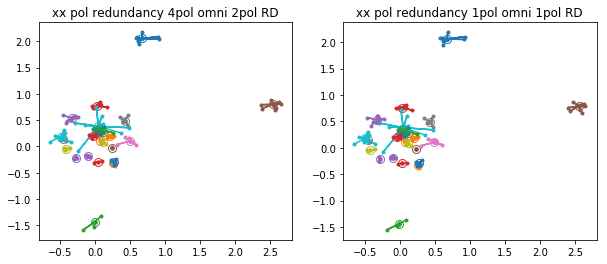

In [32]:
reds = info.get_reds()

plt.figure(figsize=(10,4))
for chan in range(600,601):

    plt.subplot(121)
    cal_1pol_dc = datacontainer.DataContainer(calibrated_1pol)
    for red in reds[0:len(reds)/4]:
        cal_vis = [cal_1pol_dc[bl]['xx'][0,chan] for bl in red]
        model_vis = v3_fc_1pol['xx'][red[0]][0,chan]
        toPlot = np.ravel(np.column_stack((cal_vis, model_vis*np.ones_like(cal_vis))))
        line = plt.plot(np.real(toPlot), np.imag(toPlot),'.-')
        plt.plot(np.real(model_vis), np.imag(model_vis),'o', c=line[0].get_color(), ms=8, fillstyle='none',)
        plt.title('xx pol redundancy 4pol omni 2pol RD')

    plt.subplot(122)
    cal_2pol_dc = datacontainer.DataContainer(calibrated_2pol)
    for red in reds[0:len(reds)/4]:
        cal_vis = [cal_2pol_dc[bl]['xx'][0,chan] for bl in red]
        model_vis = v3_fc_2pol['xx'][red[0]][0,chan]
        toPlot = np.ravel(np.column_stack((cal_vis, model_vis*np.ones_like(cal_vis))))
        line = plt.plot(np.real(toPlot), np.imag(toPlot),'.-')
        plt.plot(np.real(model_vis), np.imag(model_vis),'o', c=line[0].get_color(), ms=8, fillstyle='none',)
        plt.title('xx pol redundancy 1pol omni 1pol RD')
        
    plt.show()

In [33]:
def chisq(reds, dc, v, g, pols):
    chisq, count = 0.0, 0
    for red in reds:
        for bl in red:
            for pol in pols:
                count += 1
                chisq += np.abs(dc[bl][pol] - v[pol][red[0]] * g[pol[0]][bl[0]] * np.conj(g[pol[1]][bl[1]]))**2
    return chisq/count

invalid value encountered in divide


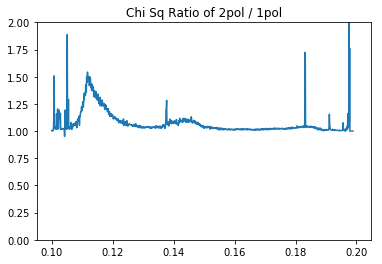

In [34]:
dcfc = datacontainer.DataContainer(datapack_fc)
chisq_2pol = chisq(reds[0:len(reds)/4], dcfc, v3_fc_2pol, g3_fc_2pol, ['xx','yy'])
chisq_1pol = chisq(reds[0:len(reds)/4], dcfc, v3_fc_1pol, g3_fc_1pol, ['xx','yy'])
plt.figure()
plt.plot(freqs, chisq_2pol[0,:]/chisq_1pol[0,:])
plt.ylim([0,2])
plt.title('Chi Sq Ratio of 2pol / 1pol')

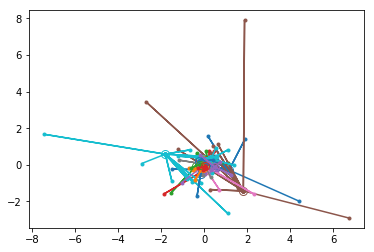

In [35]:
#calibrated_1pol = calibrate_datapack(datapack_fc, g3_fc_1pol)
calibrated_2pol_noRD = calibrate_datapack(datapack_fc, g2_fc)
cal_2pol_noRD_dc = datacontainer.DataContainer(calibrated_2pol_noRD)

chan = 102
plt.figure()
for red in reds[0:len(reds)/4]:
    cal_vis = [cal_2pol_noRD_dc[bl]['xy'][0,chan] for bl in red]
    model_vis = v2_fc_copy['xy'][red[0]][0,chan]
    toPlot = np.ravel(np.column_stack((cal_vis, model_vis*np.ones_like(cal_vis))))
    line = plt.plot(np.real(toPlot), np.imag(toPlot),'.-')
    plt.plot(np.real(model_vis), np.imag(model_vis),'o', c=line[0].get_color(), ms=8, fillstyle='none',)


In [36]:
reds = info.get_reds()
std_ratios_1pol = {red[0]: np.zeros(1024) for red in reds[0:len(reds)/4]}
std_ratios_2pol = {red[0]: np.zeros(1024) for red in reds[0:len(reds)/4]}
cal_1pol_dc = datacontainer.DataContainer(calibrated_1pol)
for red in reds[0:len(reds)/4]:
    vis_1pol_xy = [cal_1pol_dc[bl]['xy'][0,:] for bl in red]
    vis_2pol_xy = [cal_2pol_dc[bl]['xy'][0,:] for bl in red]    
    vis_1pol_yx = [cal_1pol_dc[bl]['yx'][0,:] for bl in red]
    vis_2pol_yx = [cal_2pol_dc[bl]['yx'][0,:] for bl in red]    
    std_ratios_1pol[red[0]] = np.std(vis_1pol_xy,axis=0) / np.abs(np.mean(vis_1pol_xy,axis=0))
    std_ratios_1pol[red[0]] += np.std(vis_1pol_yx,axis=0) / np.abs(np.mean(vis_1pol_yx,axis=0))

    std_ratios_2pol[red[0]] = np.std(vis_2pol_xy,axis=0) / np.abs(np.mean(vis_2pol_xy,axis=0))
    std_ratios_2pol[red[0]] += np.std(vis_2pol_yx,axis=0) / np.abs(np.mean(vis_2pol_yx,axis=0))

#     stds_1pol[red[0]] = np.std([cal_1pol_dc[bl]['xy'][0,:] for bl in red],axis=0) + np.std([cal_1pol_dc[bl]['yx'][0,:] for bl in red],axis=0)
#     stds_2pol[red[0]] = np.std([cal_2pol_dc[bl]['xy'][0,:] for bl in red],axis=0) + np.std([cal_2pol_dc[bl]['yx'][0,:] for bl in red],axis=0)

plt.figure()
for key in stds_1pol.keys():
    plt.plot(freqs, std_ratios_1pol[key],label=key)
    #plt.plot(freqs, std_ratios_2pol[key],label=key)    
#plt.ylim([.8, 1.2])
plt.title('1pol cross-pol red stds / 2pol cross-pol red stds')


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


NameError: name 'stds_1pol' is not defined

In [ ]:
reds = info.get_reds()
stds_1pol = {red[0]: np.zeros(1024) for red in reds[0:len(reds)/4]}
stds_2pol = {red[0]: np.zeros(1024) for red in reds[0:len(reds)/4]}
cal_1pol_dc = datacontainer.DataContainer(calibrated_1pol)
for red in reds[0:len(reds)/4]:
    stds_1pol[red[0]] = np.std([cal_1pol_dc[bl]['xx'][0,:] for bl in red],axis=0) + np.std([cal_1pol_dc[bl]['yy'][0,:] for bl in red],axis=0)
    stds_2pol[red[0]] = np.std([cal_2pol_dc[bl]['xx'][0,:] for bl in red],axis=0) + np.std([cal_2pol_dc[bl]['yy'][0,:] for bl in red],axis=0)

plt.figure()
for key in stds_1pol.keys():
    plt.plot(freqs, stds_1pol[key] / stds_2pol[key], lw=.5, label=key)
plt.ylim([.5,1.5])
plt.title('1pol same-pol red stds / 2pol same-pol red stds')


# Comparison of 1pol Cal 1pol RD with 4pol Cal 2pol RD:
TODO:
* ~~Compare noise on gains~~
* ~~Compare noise on visibility models~~
* Compare broad freq strucutre of gain solution or visibilities
* Compare redundancy on xy and yx visbilities
* Compare redundnacy on xx and yy, and also redundancy
* See if xy and yx noise level is comparable to that on xx and yy raw visibilties (even though xx and yy have higher SNR)


# What if I inject noise into just xy and yx visibilties?

In [ ]:
print np.mean(np.abs(datapack_fc[9,20]['yx']))
print datapack_fc[9,20]['yx'].shape
np.random.randn(1,len(freqs)).shape

In [ ]:
# for noise_level in [.00001, .0001, .001, .01, .1, 1, 10]:

#     datapack_fc, wgtpack_fc = deepcopy(datapack), deepcopy(wgtpack)
#     for bl in datapack_fc.keys():
#         if bl[0] not in ex_ants and bl[1] not in ex_ants:
#             for pol in datapack_fc[bl].keys():
#                 datapack_fc[bl][pol] = datapack_fc[bl][pol][0:1,:] / (g0[pol[0]][bl[0]] * np.conj(g0[pol[1]][bl[1]]))
#                 datapack_fc[bl][pol] = np.array(datapack_fc[bl][pol], dtype=np.complex64)
#                 if pol is 'xy' or pol is 'yx':
#                     datapack_fc[bl][pol] = noise_level * (np.random.randn(1,len(freqs)) + 1.0j*(np.random.randn(1,len(freqs))))
#                     #datapack_fc[bl][pol] += noise_level * (np.random.randn(len(freqs)) + 1.0j*(np.random.randn(len(freqs))))
#                     datapack_fc[bl][pol] = np.array(datapack_fc[bl][pol], dtype=np.complex64)

#     unit_gains = deepcopy(g0)
#     for antpol in unit_gains.keys():
#         for ant in unit_gains[antpol].keys():
#             unit_gains[antpol][ant] = np.ones_like(unit_gains[antpol][ant])
#             unit_gains[antpol][ant] = np.array(unit_gains[antpol][ant], dtype=np.complex64)

#     m1_fc, g1_fc, v1_fc = omnical.calib.logcal(datapack_fc, info, gains=unit_gains)
#     m2_fc, g2_fc, v2_fc = omnical.calib.lincal(datapack_fc, info, gains=g1_fc, vis=v1_fc)
#     g3_fc_4pol, v3_fc_4pol = omni.remove_degen(info, g2_fc, v2_fc, unit_gains, minV=False)
#     del v2_fc['xy']
#     del v2_fc['yx']
#     g3_fc_2pol, v3_fc_2pol = omni.remove_degen(info, g2_fc, v2_fc, unit_gains, minV=False)

#     plot_amp_and_phase(g3_fc_4pol['x'], 'FCed 4pol-RD omnical x gain', plt.plot)
#     plt.suptitle('Noise Level: ' + str(noise_level))    
#     plot_amp_and_phase(v3_fc_4pol['xx'], 'FCed 4pol-RD omnical xx vis', plt.semilogy)
#     plt.suptitle('Noise Level: ' + str(noise_level))    
    
#     plot_amp_and_phase(g3_fc_2pol['x'], 'FCed 2pol-RD omnical x gain', plt.plot)
#     plt.suptitle('Noise Level: ' + str(noise_level))    
#     plot_amp_and_phase(v3_fc_2pol['xx'], 'FCed 2pol-RD omnical xx vis', plt.semilogy)
#     plt.suptitle('Noise Level: ' + str(noise_level))    
    
    
#     #plt.suptitle('Additional Noise Level: ' + str(noise_level))
    

### TODO:

* Perhaps the problem is the relative firstcal solution between x and y. They are both made to average to 0, but what if they have an average displacement from each other???

In [ ]:
# print ants
# print ex_ants

In [ ]:
# plt.figure()
# for ant in ants:
#     if fc_delays.has_key((ant,'x')):
#         delaydiffs = 1e9*fc_delays[ant,'x'] - 1e9*fc_delays[ant,'y']
#         if np.mean(np.abs(delaydiffs)) > 5: 
#             plt.plot(delaydiffs, label=ant)
# plt.xlabel('Integration')
# #plt.ylabel('Delay - Mean Delay (ns)')
# plt.legend(fontsize=8)

In [ ]:
# print ants

In [ ]:
# datapack, wgtpack = firstcal.UVData_to_dict([data])
# _, g0, _, _ = omni.from_fits(fcFileList)


# plt.figure()

# for ant1,ant2 in [(9,20),(20,89), (72,112)]:#, (72,97), (88,89)]:
#     xydata = datapack[ant1,ant2]['xy'] / (g0['x'][ant1] * g3_fc['x'][ant1] * np.conj(g0['y'][ant2] * g3_fc['y'][ant2]))
# #    yxdata = datapack[ant1,ant2]['yx'] / (g0['y'][ant1] * g3_fc['y'][ant1] * np.conj(g0['x'][ant2] * g3_fc['x'][ant2]))
# #    plt.plot(np.unwrap(np.angle(np.mean(xydata * np.conj(yxdata), axis=0))[150:850]))
#     plt.plot((np.angle(xydata[0,:])))
#     #plt.plot(np.angle(xydata * np.conj(yxdata))[0,:])
#     #plt.plot(np.angle(np.mean(xydata * np.conj(yxdata), axis=0)), label=(ant1,ant2))
# plt.legend()

In [ ]:
# plt.figure()
# plt.plot(np.angle(v2_copy['xx'][9,20])[0,:])
# plt.plot(np.angle(v3_fc['xx'][9,20])[0,:])

In [ ]:
# print v2_copy['xy'].keys()

In [ ]:
# plt.figure(figsize=(10,4))
# bls = [(9,20),(20,89), (72,112), (80,104), (31,65)]
# for ant1,ant2 in bls:
#     xydata = datapack[ant1,ant2]['xy'] / (g0['x'][ant1] * g3_fc['x'][ant1] * np.conj(g0['y'][ant2] * g3_fc['y'][ant2]))
#     plt.subplot(121)
#     plt.plot(np.unwrap(np.angle(xydata[0,420:])))
#     plt.title('xy')
#     plt.ylim([-10,10])
#     plt.subplot(122)
#     yxdata = datapack[ant1,ant2]['yx'] / (g0['y'][ant1] * g3_fc['y'][ant1] * np.conj(g0['x'][ant2] * g3_fc['x'][ant2]))
#     plt.plot(np.unwrap(np.angle(yxdata[0,420:])))
#     plt.title('yx')
#     plt.ylim([-10,10])

# plt.figure(figsize=(10,4))
# for ant1,ant2 in bls:
#     xydata = datapack[ant1,ant2]['xy'] / (g0['x'][ant1] * g2_fc['x'][ant1] * np.conj(g0['y'][ant2] * g2_fc['y'][ant2]))
#     plt.subplot(121)
#     plt.title('xy')    
#     plt.plot(np.unwrap(np.angle(xydata[0,420:])))
#     plt.ylim([-10,10])
#     plt.subplot(122)
#     plt.title('yx')
#     yxdata = datapack[ant1,ant2]['yx'] / (g0['y'][ant1] * g2_fc['y'][ant1] * np.conj(g0['x'][ant2] * g2_fc['x'][ant2]))
#     plt.plot(np.unwrap(np.angle(yxdata[0,420:])))
#     plt.ylim([-10,10])
    
# plt.figure(figsize=(10,4))
# for ant1,ant2 in bls:
#     xydata = datapack[ant1,ant2]['xy'] / (g0['x'][ant1] * np.conj(g0['y'][ant2]))
#     plt.subplot(121)
#     plt.title('xy')    
#     plt.plot(np.unwrap(np.angle(xydata[0,420:])))
#     plt.ylim([-10,10])
#     plt.subplot(122)
#     plt.title('yx')
#     yxdata = datapack[ant1,ant2]['yx'] / (g0['y'][ant1] * np.conj(g0['x'][ant2]))
#     plt.plot(np.unwrap(np.angle(yxdata[0,420:])))
#     plt.ylim([-10,10])

## ~~Loop through relative x and y FC delays~~ This didn't help.

In [ ]:
# unit_gains = deepcopy(g0)
# for antpol in unit_gains.keys():
#     for ant in unit_gains[antpol].keys():
#         unit_gains[antpol][ant] = np.ones_like(unit_gains[antpol][ant])
#         unit_gains[antpol][ant] = np.array(unit_gains[antpol][ant], dtype=np.complex64)

# for relative_xy_delay in np.linspace(-50,50,10):
#     freqs = data.freq_array[0,:] / 1e9
#     datapack_fc, wgtpack_fc = firstcal.UVData_to_dict([data])        
#     for bl in datapack_fc.keys():
#         if bl[0] not in ex_ants and bl[1] not in ex_ants:
#             for pol in datapack_fc[bl].keys():
#                 datapack_fc[bl][pol] = datapack_fc[bl][pol][0:1,:] / (g0[pol[0]][bl[0]] * np.conj(g0[pol[1]][bl[1]]))
#                 if pol is 'xy': 
#                     datapack_fc[bl][pol] = datapack_fc[bl][pol] / np.exp(1.0j * freqs * relative_xy_delay)
#                 if pol is 'yx': 
#                     datapack_fc[bl][pol] = datapack_fc[bl][pol] / np.exp(-1.0j * freqs * relative_xy_delay)                                        
#                 datapack_fc[bl][pol] = np.array(datapack_fc[bl][pol], dtype=np.complex64)
#     m1_fc, g1_fc, v1_fc = omnical.calib.logcal(datapack_fc, info, gains=unit_gains)
#     m2_fc, g2_fc, v2_fc = omnical.calib.lincal(datapack_fc, info, gains=g1_fc, vis=v1_fc)
    
#     g3_fc, v3_fc = omni.remove_degen(info, g2_fc, v2_fc, unit_gains, minV=False)
#     plt.figure(figsize=(10,4))
#     for ant in g3_fc['x'].keys():
#         plt.suptitle('relative_xy_delay = ' + str(relative_xy_delay))
#         plt.subplot(121)
#         plt.plot(np.abs(g3_fc['x'][ant][0,:]), '-', lw=.5)
#         plt.title('FC-precorrected omnical gain amplitudes')
#         plt.subplot(122)
#         plt.title('FC-precorrected omnical gain phases')
#         plt.plot(np.angle(g3_fc['x'][ant][0,:]), '-', lw=.5)

In [ ]:
#TODO: 2-pol 